In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 17:10:53 2020

@author: wanxiang.shen@u.nus.edu
"""

import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.metrics import auc as calculate_auc

import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggModel

np.random.seed(666) #just for reaptable results

def prc_auc_score(y_true, y_score):
    precision, recall, threshold  = precision_recall_curve(y_true, y_score) #PRC_AUC
    auc = calculate_auc(recall, precision)
    return auc

In [2]:
df1 = pd.read_excel('./proteins_processed.xlsx', index_col = 0)
df2 = pd.read_excel('./Metabolites_processed.xlsx', index_col = 0)
df2 = df2.loc[df1.index]

df = df1.join(df2)
dfx = df[df.columns[2:]]


In [3]:
dfx.shape

(41, 1486)

In [4]:
df.to_excel('./proteins_metabolites.xlsx')

In [5]:
dfx.shape, df2.shape, df1.shape

((41, 1486), (41, 847), (41, 641))

In [6]:
dfy = df[['Severe']]*1.

In [7]:
mp = AggMap(dfx, metric = 'correlation')
mp.fit(cluster_channels = 5, verbose = 0,)

2021-01-22 16:10:51,881 - INFO - [bidd-aggmap] - Calculating distance ...
2021-01-22 16:10:52,056 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 1486/1486 [00:02<00:00, 656.46it/s]


2021-01-22 16:11:38,707 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2021-01-22 16:11:46,320 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2021-01-22 16:11:49,973 - INFO - [bidd-aggmap] - Finished


In [8]:
mp.fmap_shape

(39, 39)

In [48]:
#mp.plot_scatter()
mp.plot_scatter(enabled_data_labels = True, htmlname = 'covid-19.severe.cluster5_scatter',radius=3)

2021-01-25 14:44:19,812 - INFO - [bidd-aggmap] - generate file: ./covid-19.severe.cluster5_scatter_feature points_1486_correlation_umap_scatter
2021-01-25 14:44:19,851 - INFO - [bidd-aggmap] - save html file to ./covid-19.severe.cluster5_scatter_feature points_1486_correlation_umap_scatter


In [50]:
mp.plot_grid( htmlname = 'covid-19.severe.cluster5_grid')

2021-01-25 14:46:27,388 - INFO - [bidd-aggmap] - generate file: ./covid-19.severe.cluster5_grid_feature points_1486_correlation_umap_mp
2021-01-25 14:46:27,422 - INFO - [bidd-aggmap] - save html file to ./covid-19.severe.cluster5_grid_feature points_1486_correlation_umap_mp


In [11]:
tr = df[df['Train_Test'] == 'Train'].index
ts = df[df['Train_Test'] == 'Test'].index

In [12]:
y = pd.get_dummies(dfy['Severe'])[[1,0]]

Y = y.loc[tr].values
X = dfx.loc[tr].values

Y_test = y.loc[ts].values
X_test = dfx.loc[ts].values

In [13]:
mp.save('./COV-S.mp')

['./COV-S.mp']

In [31]:
trainX = mp.batch_transform(X, scale_method = 'standard')
testX = mp.batch_transform(X_test, scale_method = 'standard')

print("\n input train and test X shape is %s, %s " % (trainX.shape,  testX.shape))

# fit the model
clf = AggModel.MultiClassEstimator(epochs = 50,  gpuid = 5, batch_size = 1, conv1_kernel_size = 5 ,  verbose = 0,) 
clf.fit(trainX, Y)

# save the model for explaination
clf._model.save( './model.h5')

# make prediction
y_true = Y_test[:,0]
y_pred = clf.predict(testX)[:,0]
y_score = clf.predict_proba(testX)[:,0]

res = {'index':ts, 'y_true':y_true, 'y_score':y_score}
dfres = pd.DataFrame(res)


100%|##########| 10/10 [00:00<00:00, 153.42it/s]



 input train and test X shape is (31, 39, 39, 5), (10, 39, 39, 5) 
MultiClassEstimator(batch_size=1, conv1_kernel_size=5, epochs=50, gpuid='5')


In [32]:
dfres.to_csv('./test_predict_res.csv')

In [33]:
dfres = pd.DataFrame(res)
dfres

y_true = dfres.y_true.values
y_pred = dfres.y_score.values.round()
y_score = dfres.y_score.values


tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

acc = (tp + tn) / sum([tn, fp, fn, tp])

sensitivity = tp / sum([tp, fn])
specificity = tn / sum([tn, fp])

prc_auc = prc_auc_score(y_true, y_score)
roc_auc = roc_auc_score(y_true, y_score)

precision = tp / sum([tp, fp])
recall =  tp / sum([tp, fn]) #equals to sensitivity


res = {
    
       'accuracy':acc, 

       'prc_auc':prc_auc, 
       'roc_auc':roc_auc,

       'sensitivity': sensitivity, 
       'specificity': specificity,

       'precision':precision,
       'recall':recall,

       'F1': 2*precision*sensitivity/(precision+sensitivity)
      }

res

{'accuracy': 0.8,
 'prc_auc': 1.0,
 'roc_auc': 1.0,
 'sensitivity': 1.0,
 'specificity': 0.6666666666666666,
 'precision': 0.6666666666666666,
 'recall': 1.0,
 'F1': 0.8}

In [34]:
from molmap import loadmap
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import KFold

import warnings, os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import copy
from tqdm import tqdm


warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"]="7"


def CalcFeatImp(model, mp, arrX, dfY, task_type = 'classification', sigmoidy = False):
    '''
    Forward prop. Feature importance
    '''
    
    if task_type == 'classification':
        f = log_loss
    else:
        f = mean_squared_error
        
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    grid = mp.plot_grid()
    Y_true = dfY.values
    df_grid = mp.df_grid.sort_values(['y', 'x']).reset_index(drop=True)
    Y_prob = model.predict(arrX)
    N, W, H, C = arrX.shape
    
    if (sigmoidy) & (task_type == 'classification'):
        Y_prob = sigmoid(Y_prob)

    final_res = {}
    for k, col in enumerate(dfY.columns):
        print('calculating feature importance for %s ...' % col)
        
        results = []
        loss = f(Y_true[:, k].tolist(), Y_prob[:, k].tolist())
        for i in tqdm(range(len(df_grid)), ascii= True):
            ts = df_grid.iloc[i]
            y = ts.y
            x = ts.x
            X1 = copy(arrX)
            X1[:, y, x,:] = np.full(X1[:, y, x,:].shape, fill_value = arrX.min())
            #Y1 = model.predict(X1)
            Y_pred_prob = model.predict(X1)
            if (sigmoidy) & (task_type == 'classification'):
                Y_pred_prob = sigmoid(Y_pred_prob)
            mut_loss = f(Y_true[:, k].tolist(), Y_pred_prob[:, k].tolist()) 
            res =  mut_loss - loss # if res > 0, important, othervise, not important
            results.append(res)
            
        final_res.update({col:results})
    df = pd.DataFrame(final_res)
    df.columns = df.columns + '_importance'
    df = df_grid.join(df)
    return df

In [77]:
arrX = trainX
dfY = pd.DataFrame(Y, columns = ['severe', 'non-severe'])
model = clf._model
df_imp = CalcFeatImp(model, mp, arrX, dfY, task_type = 'classification', sigmoidy = False)


  0%|          | 2/1521 [00:00<01:22, 18.39it/s]

2021-01-26 15:18:48,201 - INFO - [bidd-aggmap] - generate file: ./feature points_1486_correlation_umap_mp
2021-01-26 15:18:48,240 - INFO - [bidd-aggmap] - save html file to ./feature points_1486_correlation_umap_mp
calculating feature importance for severe ...


  0%|          | 2/1521 [00:00<01:20, 18.95it/s]

calculating feature importance for non-severe ...


100%|##########| 1521/1521 [01:22<00:00, 18.44it/s]


## feature importance based on training

,x,y,v,Subtypes,colors,severe_importance,non-severe_importance
230,35,5,"sphingomyelin (d18:2/23:0, d18:1/23:1, d17:1/2...",cluster_02,#08ff00,0.053694,0.053694
1320,33,33,ergothioneine,cluster_03,#00fff6,0.050855,0.050855
308,35,7,"sphingomyelin (d18:1/20:1, d18:2/20:0)*",cluster_02,#08ff00,0.050171,0.050171
228,33,5,thyroxine,cluster_02,#08ff00,0.048238,0.048238
1244,35,31,N-acetyltryptophan,cluster_03,#00fff6,0.047114,0.047114
1242,33,31,1-carboxyethylleucine,cluster_03,#00fff6,0.045324,0.045324
464,35,11,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0...,cluster_02,#08ff00,0.045195,0.045195
462,33,11,1-(1-enyl-stearoyl)-2-linoleoyl-GPE (P-18:0/18...,cluster_02,#08ff00,0.044782,0.044782
542,35,13,1-arachidonoyl-GPC* (20:4)*,cluster_02,#08ff00,0.044193,0.044193
512,5,13,Q6EMK4,cluster_05,#ee00ff,0.042621,0.042621


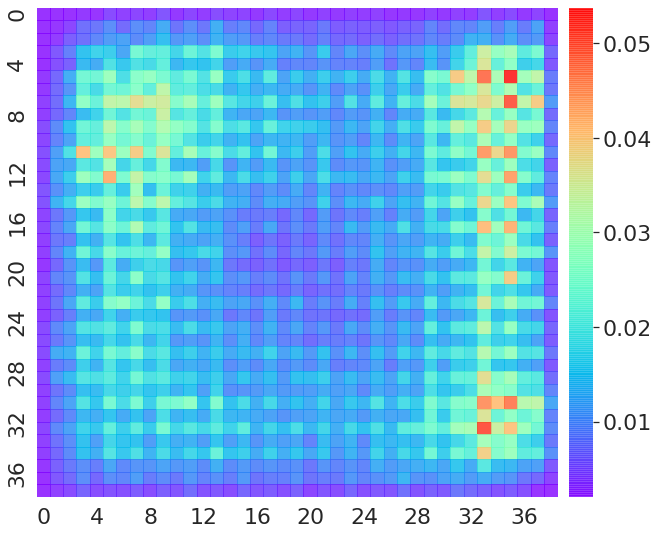

In [78]:
sns.set(style='white',  font='sans-serif', font_scale=2)
fig, ax  = plt.subplots(1, 1, figsize=(10, 9))

IMPM = df_imp['severe_importance'].values.reshape(*mp.fmap_shape)
sns.heatmap(IMPM,  
            cmap = 'rainbow', alpha = 0.8, xticklabels=4, ax =ax,
            yticklabels=4,  vmin = 0.002,
            cbar_kws = {'fraction':0.046, 'pad':0.02})

df_imp = df_imp.sort_values('severe_importance', ascending=False)
df_imp.to_csv('./feature_imp_test.csv')
df_imp.head(30)

## significant test

In [79]:
df_save = df_imp[['x', 'y', 'v', 'Subtypes', 'colors', 'severe_importance']]
df_save = df_save.set_index('v')

from scipy.stats import mannwhitneyu
p_values = []
for c in df_save.index:
    if c != 0:
        v1 = dfx[[c]]
        v2 = dfy[['Severe']]
        xx = v1.join(v2).groupby('Severe')[c].apply(lambda x:x.to_list())    
        s, p = mannwhitneyu(xx[0], xx[1], alternative='two-sided')
        p_values.append(p)
    else:
        p_values.append(None)
df_save['mannwhitneyu_p-value'] = p_values
df_save.index.name = 'feature points'

df_save.to_excel('./feature_importance.xlsx')

In [80]:
X_new = mp.batch_transform(dfx.values, scale_method = 'standard')
dfyy = dfy.reset_index()

100%|##########| 41/41 [00:04<00:00,  9.58it/s]


In [81]:
severe_list = ['XG40', 'XG42', 'XG43', 'XG44', 'XG45', 'XG46']
non_severe_list =  ['XG20', 'XG21', 'XG22', 'XG23', 'XG24', 'XG25']

## feature maps

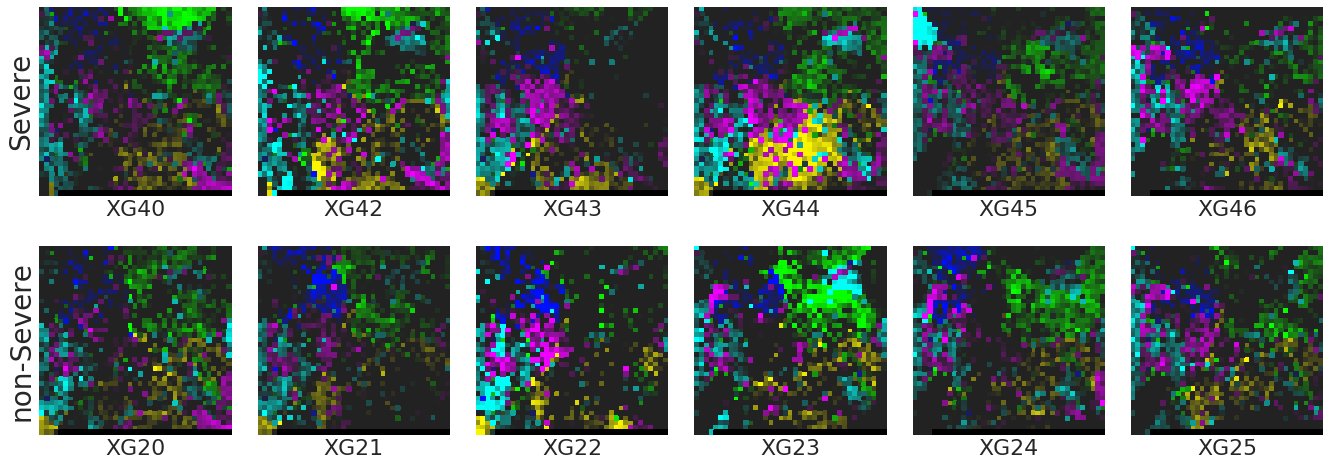

In [261]:
from aggmap import show

idx = dfyy.groupby(['Severe']).apply(lambda x:x.index.tolist())

rows = [severe_list, non_severe_list]
row_names = ['Severe', 'non-Severe']

n = 6
fontsize = 22

fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(19,7), sharex = True, sharey = True)



for row, row_ax in zip(rows, axes):
    pidx = row        
    for pid_name, ax in zip(pidx, row_ax):
        pid = dfyy[dfyy['index'] == pid_name].index[0]
        x = X_new[pid]
        #ax.imshow(X_new[pid].sum(axis=-1), cmap = 'jet')
        show.imshow(x, ax = ax,  mode = 'dark', color_list= pd.Series(mp.colormaps).tolist(), x_max=x.max()-2, vmin=-0.1, ) # vmax=x.max()
        ax.set_xlabel(pid_name, fontsize = fontsize) 

for ax, row in zip(axes[:,0], row_names):
    ax.set_ylabel(row, fontsize = 28)  

fig.tight_layout()
fig.savefig('./fmp.png', bbox_inches='tight', dpi=400) 

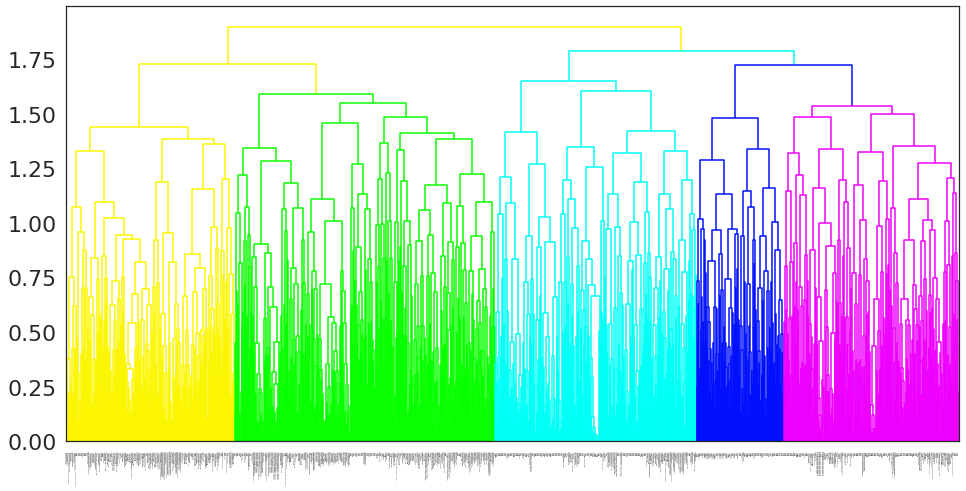

In [83]:
fig_tree = mp.plot_tree(leaf_font_size = 1)
fig_tree.savefig('covid-19.cluster5_tree.png', bbox_inches='tight', dpi=300)

In [239]:
selected = df_imp.head(50) #df_imp[df_imp['severe_importance'] > 0.03]
select_markers = selected.v.tolist()

In [240]:
data = mp.df_scatter.set_index('IDs').loc[select_markers][['x', 'y']]
data = data.join(selected.set_index('v')['severe_importance'])
data['Type'] = data.index.isin(df2.columns)
data['Type'] =  data['Type'].map({True:'Metabolites', False:'Proteins'})
data['Importance'] = data['severe_importance']

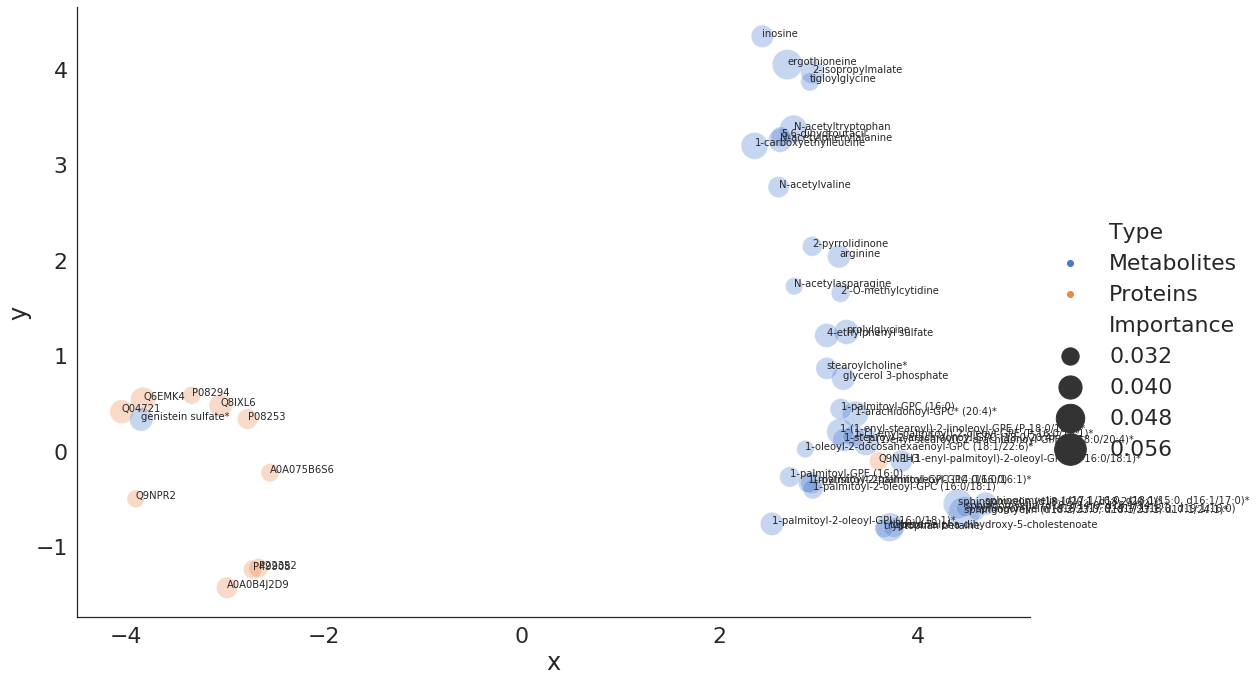

In [241]:
# Plot miles per gallon against horsepower with other semantics
g = sns.relplot(x="x", y="y", size="Importance",   hue="Type", 
            sizes=(300, 1000), alpha=.3, palette="muted", height=10, aspect = 1.5,
             data=data)
#g.fig.set_size_inches(15,6)

for i in range(len(data)):
    ts = data.iloc[i]
    g.ax.text(ts.x, ts.y, ts.name, fontdict = {'fontsize':10})
    

#g.tight_layout()
g.savefig('./imp.pdf', bbox_inches='tight', dpi=400) 

In [242]:
data.to_excel('fig2.xlsx')

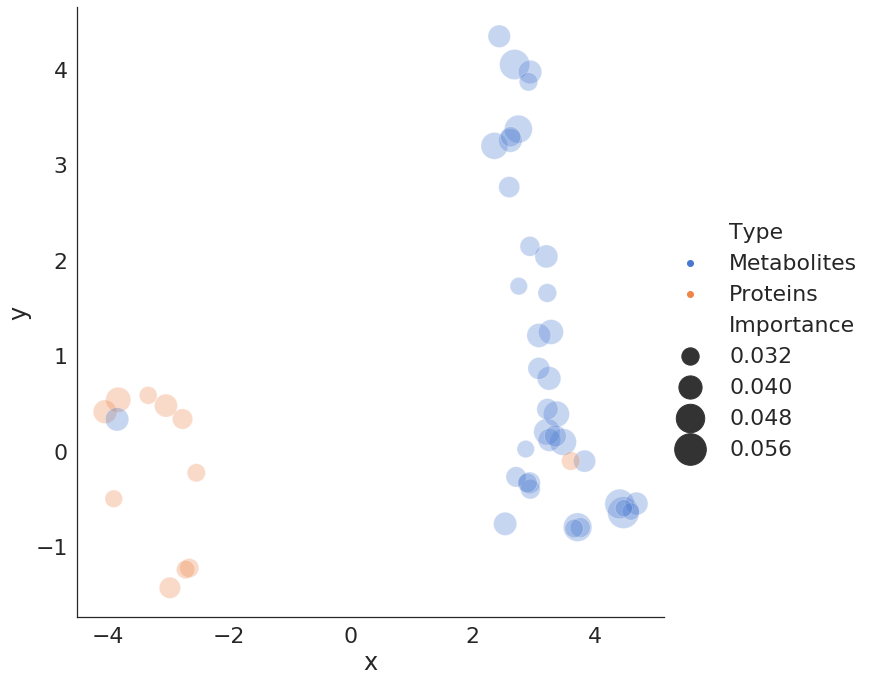

In [243]:
# Plot miles per gallon against horsepower with other semantics
g = sns.relplot(x="x", y="y", size="Importance",   hue="Type", 
            sizes=(300, 1000), alpha=.3, palette="muted", height=10, aspect = 1.0,
             data=data)
#g.fig.set_size_inches(15,6)

# for i in range(len(data)):
#     ts = data.iloc[i]
#     g.ax.text(ts.x, ts.y, ts.name, fontdict = {'fontsize':10})
    

#g.tight_layout()
g.savefig('./imp.pdf', bbox_inches='tight', dpi=400) 

In [244]:
data[(data.y < 2.5) & (data.y > 1)]

,x,y,severe_importance,Type,Importance
IDs,,,,,
prolylglycine,3.284297,1.249015,0.042254,Metabolites,0.042254
4-ethylphenyl sulfate,3.083319,1.212547,0.041069,Metabolites,0.041069
arginine,3.207548,2.040293,0.039716,Metabolites,0.039716
2-pyrrolidinone,2.937277,2.145844,0.035670,Metabolites,0.035670
2'-O-methylcytidine,3.222901,1.657430,0.034427,Metabolites,0.034427
N-acetylasparagine,2.754159,1.728494,0.033142,Metabolites,0.033142


In [245]:
data[data.x > 4]

,x,y,severe_importance,Type,Importance
IDs,,,,,
"sphingomyelin (d18:2/23:0, d18:1/23:1, d17:1/24:1)*",4.472456,-0.643868,0.053694,Metabolites,0.053694
"sphingomyelin (d18:1/20:1, d18:2/20:0)*",4.411502,-0.553140,0.050171,Metabolites,0.050171
"sphingomyelin (d17:1/16:0, d18:1/15:0, d16:1/17:0)*",4.686434,-0.549192,0.039656,Metabolites,0.039656
"sphingomyelin (d18:1/17:0, d17:1/18:0, d19:1/16:0)",4.594177,-0.631140,0.033061,Metabolites,0.033061
"sphingomyelin (d18:2/14:0, d18:1/14:1)*",4.478910,-0.597369,0.032979,Metabolites,0.032979


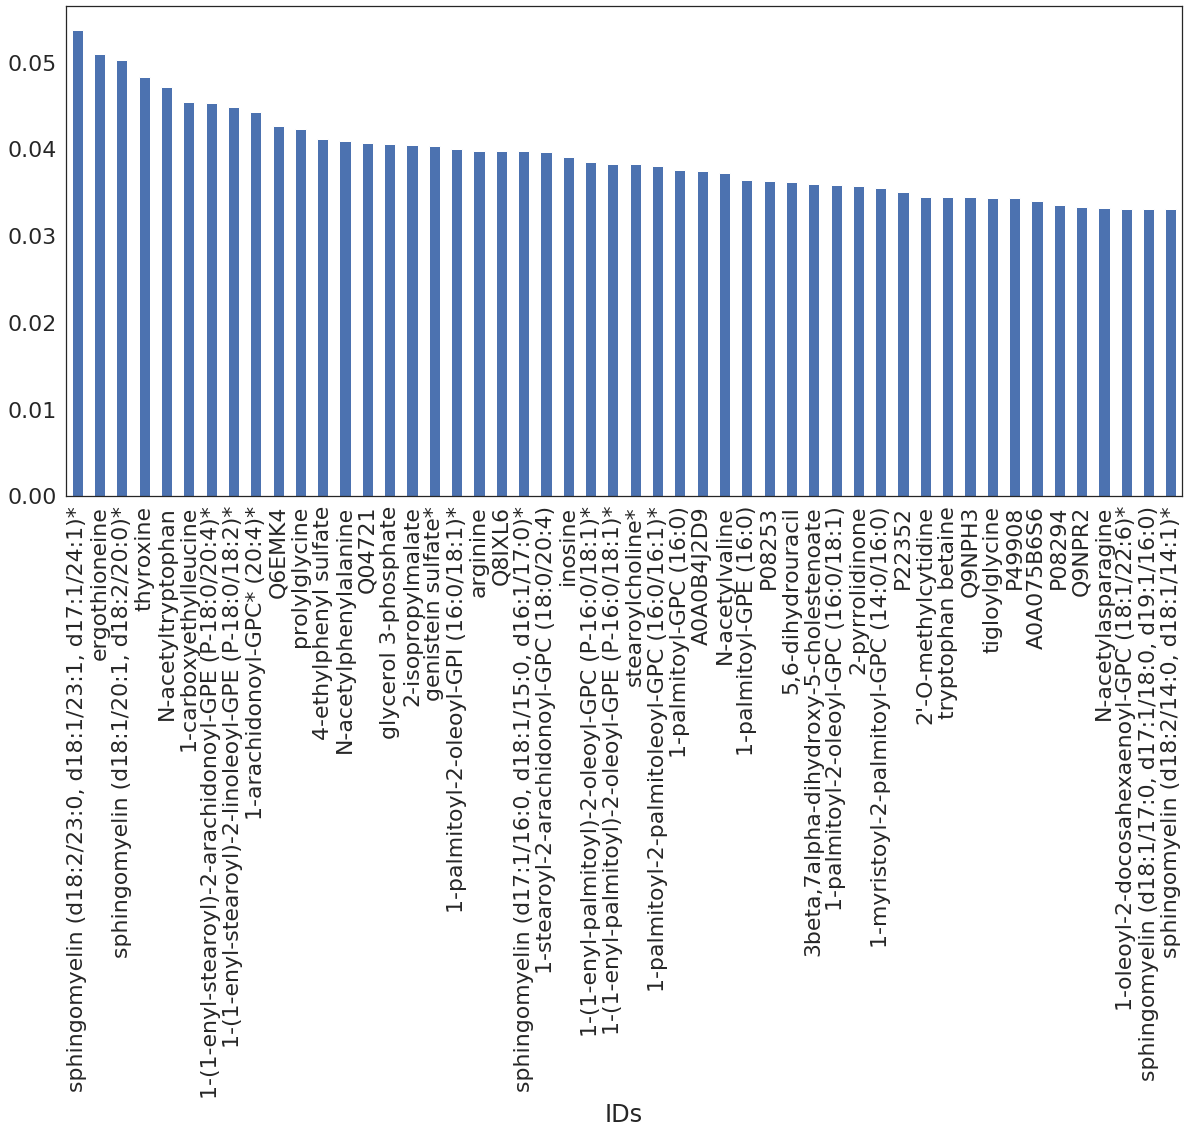

In [258]:
fig, ax  = plt.subplots(1, 1, figsize=(20, 9))
data['severe_importance'].plot(kind = 'bar')